# Energy resolution after  delta-z effect correction

## NEW, esmeralda, runs : 8182, 8183, 8184 @ Majorana


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext

import next.core.io        as nio
import next.core.selection as nsel

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Mon Apr 12 13:25:18 2021


### load data

In [5]:
def get_filename(run_number):
    datadir    = f"/data_extra2/jrenner/analysis/NEW"
    run_number = str(run_number)
    filename   = datadir + f'/{run_number}' + f'/hdf5/cdst/trigger2/cdst_combined_{run_number}' + '.h5'
    return filename

In [6]:
runs      = [8182, 8183, 8184]
filenames = [get_filename(run) for run in runs]
dfts      = [nio.get_dfesme(fname) for fname in filenames]

In [7]:
dft       = pd.concat(dfts)
len(dft)

3204576

### selections and ranges

In [8]:
ranges     = nsel.dfesme_ranges()
for key in ranges.keys():
    print(key, ranges[key])

numb_of_tracks.one (0.5, 1.5)
evt_out_of_map.False (False, False)
energy (0.0, 3.0)
energy.cs (0.65, 0.71)
energy.ds (1.55, 1.75)
energy.ph (2.5, 3.0)
enecor.cs (0.65, 0.71)
enecor.ds (1.55, 1.75)
enecor.ph (2.5, 3.0)
z_min (50.0, 500.0)
z_max (50.0, 500.0)
r_max (0.0, 180.0)
dz_track.cs (8.0, 32.0)
dz_track.ds (24.0, 72.0)
dz_track.ph (35.0, 130.0)


In [9]:
ranges['evt_out_of_map.False'] = (False, False)
ranges['numb_of_tracks.one']   = (1, 1)

selections = nsel.Selections(dft, ranges)

#selections.logical_and(('numb_of_tracks.one', 'energy', 'z_min', 'z_max', 'r_max'), 'fidutial')
selections.logical_and(('numb_of_tracks.one', 'energy', 'z_min', 'z_max', 'r_max', 
                        'evt_out_of_map.False'), 'fidutial')

print(selections)


numb_of_tracks.one : numb_of_tracks [1, 1], 1742048, 0.54361
evt_out_of_map.False : evt_out_of_map [False, False], 2755197, 0.85977
energy : energy [0.0, 3.0), 3204248, 0.99990
energy.cs : energy [0.65, 0.71), 68703, 0.02144
energy.ds : energy [1.55, 1.75), 25361, 0.00791
energy.ph : energy [2.5, 3.0), 1461, 0.00046
enecor.cs : enecor [0.65, 0.71), 71613, 0.02235
enecor.ds : enecor [1.55, 1.75), 25678, 0.00801
enecor.ph : enecor [2.5, 3.0), 2334, 0.00073
z_min : z_min [50.0, 500.0), 2707418, 0.84486
z_max : z_max [50.0, 500.0), 2741249, 0.85542
r_max : r_max [0.0, 180.0), 2400680, 0.74914
dz_track.cs : dz_track [8.0, 32.0), 1185869, 0.37005
dz_track.ds : dz_track [24.0, 72.0), 229659, 0.07167
dz_track.ph : dz_track [35.0, 130.0), 114231, 0.03565
fidutial : numb_of_tracks [1, 1] & energy [0.0, 3.0) & z_min [50.0, 500.0) & z_max [50.0, 500.0) & r_max [0.0, 180.0) & evt_out_of_map [False, False], 1112373, 0.34712



In [10]:
print(dft.columns)

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min',
       'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave',
       'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y',
       'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y',
       'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor',
       'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks',
       'evt_nhits', 'evt_out_of_map'],
      dtype='object')


### Energy 

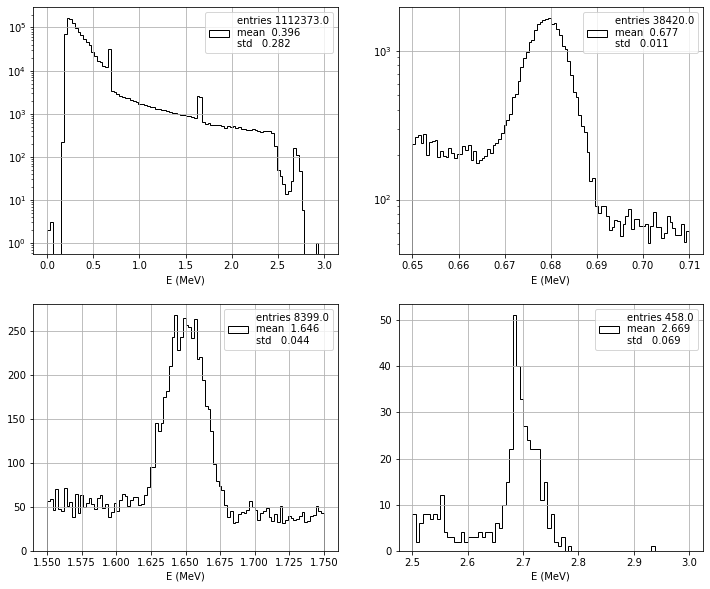

In [11]:
def plt_energies(enes, sel = None):

    xsel = sel if sel is not None else enes > np.min(enes)

    subplot = pltext.canvas(4, 2)
    subplot(1)
    pltext.hist(enes[xsel], 100, range = ranges['energy'], ylog = True, xylabels = 'E (MeV)'); 
    subplot(2)
    pltext.hist(enes[xsel], 100, range = ranges['energy.cs'], ylog = True, xylabels = 'E (MeV)');
    subplot(3)
    pltext.hist(enes[xsel], 100, range = ranges['energy.ds'], xylabels = 'E (MeV)');
    subplot(4)
    pltext.hist(enes[xsel], 80, range  = ranges['energy.ph'], xylabels = 'E (MeV)');


plt_energies(dft.energy, selections['fidutial'])
#plt_energies(dft.energy)

In [12]:
def plt_energies_fit(enes, bins, ranges, parameters, selections = None):

    nsize = len(ranges)
    subplot = pltext.canvas(nsize)
    
    selections = selections if selections is not None else nsize * [enes > np.min(enes)]
    
    epars = []
    for i in range(nsize):
        subplot(i + 1)
        xsel, xpars   = selections[i] & ut.in_range(enes, ranges[i]), parameters[i]
        _, _, _, pars, parscov, _= pltext.hfit(enes[xsel], bins, 'gaus+poly.1', 
                                               p0 = xpars, formate = '7.4f', 
                                               residuals = True);
        epars.append((pars, parscov))
 
    dpars = {}
    dpars['energy'] = [ipars[1] for ipars, iparscov in epars]
    dpars['sigma']  = [ipars[2] for ipars, iparscov in epars]
    dpars['usigma'] = [iparscov[2] for ipars, iparscov in epars]
    dpars['R']      = [235. * ipars[2]/ipars[1] for ipars, iparscov in epars]
    dpars['uR']     = [235. * iparscov[2]/ipars[1] for ipars, iparscov in epars]


    dferes = pd.DataFrame(dpars)
    
    return dferes

fidutial cuts
energy 
      energy     sigma    usigma         R        uR
0  0.679286  0.004143  0.000028  1.433263  0.009615
1  1.649761  0.013574  0.000269  1.933566  0.038352
2  2.698835  0.023781  0.001517  2.070690  0.132072
fidutial cuts


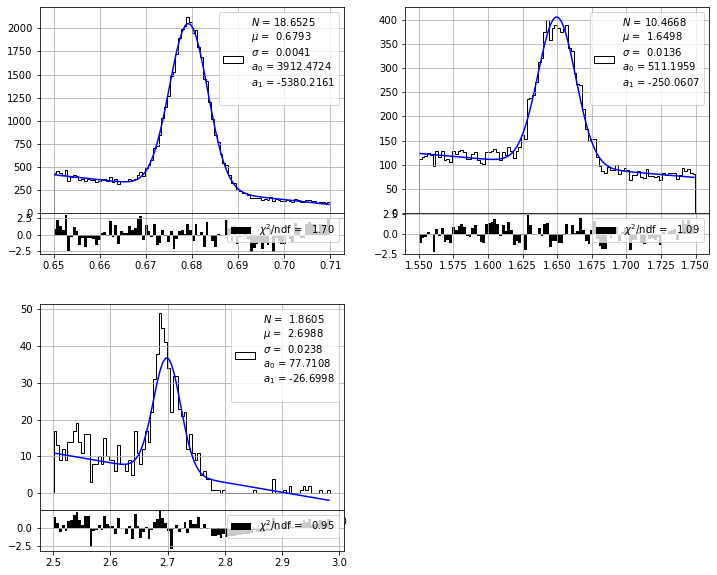

In [13]:
bins    = 100
xsel    = selections['numb_of_tracks.one']
xranges = (ranges['energy.cs'], ranges['energy.ds'], ranges['energy.ph'])
xpars0  = ((65.,  0.7, 0.013,  553., 1.9), (65.,  1.65, 0.013,  553., 1.9), (10.,  2.7, 0.013,  10., 1.))
dfenes0 = plt_energies_fit(dft.energy, bins, xranges, xpars0, 3*[xsel])
print('fidutial cuts')
print('energy \n', dfenes0)
print('fidutial cuts')

fidutial cuts
correced by dz-effect energy 
      energy     sigma    usigma         R        uR
0  0.682961  0.003592  0.000024  1.235860  0.008230
1  1.669880  0.007695  0.000140  1.082909  0.019682
2  2.768249  0.012851  0.000774  1.090901  0.065685


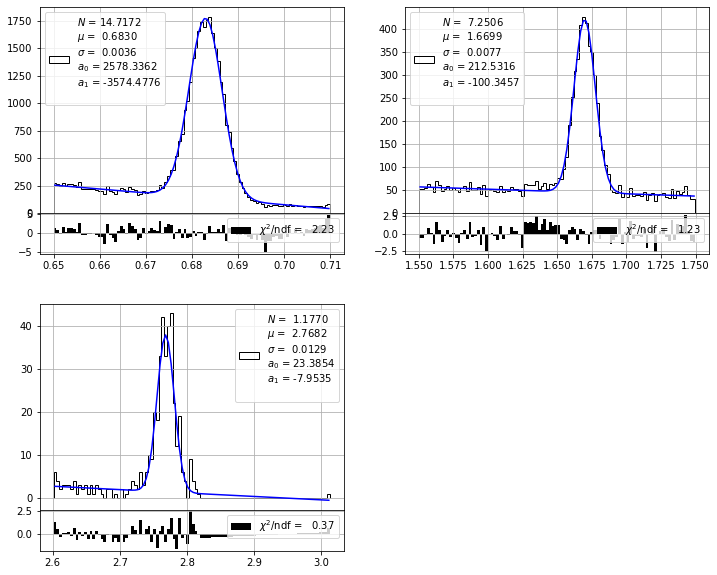

In [14]:
bins    = 100
xsel    = selections['fidutial']
xranges = [ranges['enecor.cs'], ranges['enecor.ds'], (2.6, 3.2)]
xpars0  = ((65.,  0.7, 0.01,  553., 1.9), (65.,  1.65, 0.013,  553., 1.9), (10.,  2.75, 0.01,  -5, 13.))
dfenes1 = plt_energies_fit(dft.enecor, bins, xranges, xpars0, 3*[xsel,])
print('fidutial cuts')
print('correced by dz-effect energy \n', dfenes1)

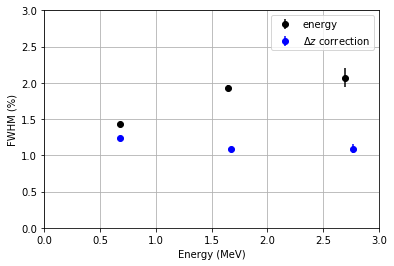

In [15]:
plt.errorbar(dfenes0.energy, dfenes0.R, yerr = dfenes0.uR, 
             marker = 'o',  ls = '', label = 'energy');
plt.errorbar(dfenes1.energy, dfenes1.R, yerr = dfenes1.uR, 
             marker = 'o', ls = '', label = r'$\Delta z$ correction')
plt.grid(); plt.xlim((0., 3.)); plt.ylim(0., 3.)
plt.xlabel('Energy (MeV)'); plt.legend(); plt.ylabel('FWHM (%)');

### extra selection in $\Delta z$ range

fidutial cuts with delta-z range
correced by dz-effect energy 
      energy     sigma    usigma         R        uR
0  0.682885  0.003550  0.000025  1.221535  0.008729
1  1.669066  0.007402  0.000145  1.042238  0.020431
2  2.767156  0.011869  0.000745  1.007930  0.063233


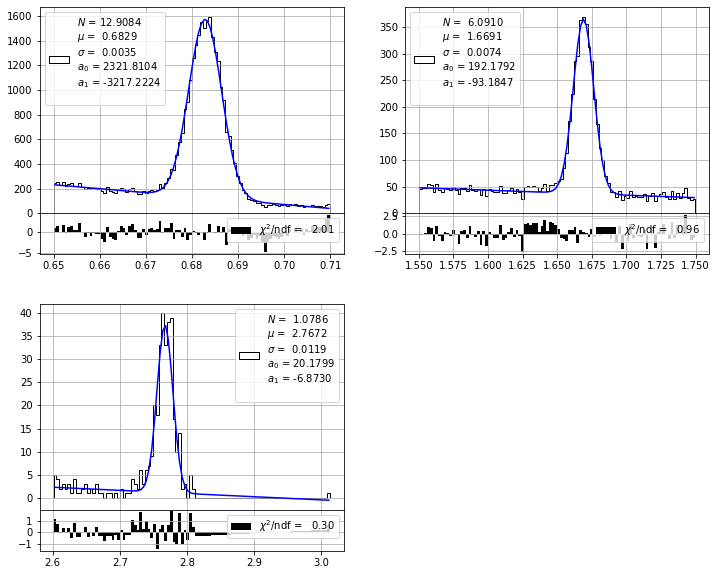

In [16]:
bins  = 100
xsels = (selections.logical_and(('fidutial', 'dz_track.cs')), 
         selections.logical_and(('fidutial', 'dz_track.ds')), 
         selections.logical_and(('fidutial', 'dz_track.ph')))
xranges = [ranges['enecor.cs'], ranges['enecor.ds'], (2.6, 3.2)]
xpars0  = ((65.,  0.7, 0.01,  553., 1.9), (10.,  1.65, 0.013,  1., 50), (10.,  2.75, 0.01,  1., 10.))
dfenes1 = plt_energies_fit(dft.enecor, bins, xranges, xpars0, xsels)
print('fidutial cuts with delta-z range')
print('correced by dz-effect energy \n', dfenes1)

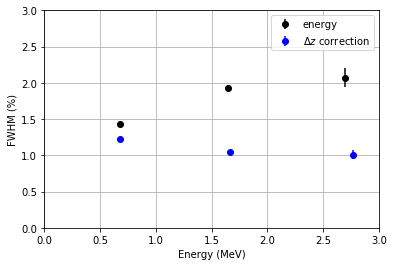

In [17]:
plt.errorbar(dfenes0.energy, dfenes0.R, yerr = dfenes0.uR, 
             marker = 'o',  ls = '', label = 'energy');
plt.errorbar(dfenes1.energy, dfenes1.R, yerr = dfenes1.uR, 
             marker = 'o', ls = '', label = r'$\Delta z$ correction')
plt.grid(); plt.xlim((0., 3.)); plt.ylim(0., 3.)
plt.xlabel('Energy (MeV)'); plt.legend(); plt.ylabel('FWHM (%)');